In [1]:
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.integrate import simpson
from scipy.sparse.linalg import spsolve
import numpy as np
import sympy as sp

In [88]:
def fd_weights ( offsets , order , show_system = False ) :

    """
    Name          : fd_weights -> finite difference weights
    Purpose       : calculate the set of coefficients for a finite difference
                    approximation of the order-th derivative using the given
                    offsets. We are essentually solving the linear system
                    A c = b, where A is the Vandermonde matrix of the offsets,
                    c is the vector of coefficients we want to find, and b is
                    a vector of zeros with a factorial(order) in the order-th
                    position.
    Author          : christlieb, augmented by Joshua Belieu.
    Date augmented  : 2025-08-26
    Last modified   : 2025-08-26
    Inputs :
        - offsets     : list. list of offsets (in units of grid stride h)
        - order       : int. order of derivative to approximate
        - show_system : bool. if True, print the system of equations being
                        solved. default is False.
    Outputs:
        - <ret>: <type> ... <meaning/units/shape>
    Dependencies:
        - None.
    """

    '''
    list of offsets (in units of grid stride h), nsimplify allows floats.
    '''

    s = [ sp.nsimplify ( offset ) for offset in offsets ]
    m = len ( s )

    '''
    the Vandermonde matrix of the offsets. the "A" in our system Ac = b
    '''

    A = sp.Matrix ([[ s[j] ** k for j in range ( m ) ] for k in range ( m )])

    '''
    a vector of zeros with a factorial(order) in the order-th position. the 
    "b" in our system Ac = b.
    '''

    b = sp.Matrix ( [ 0 ] * m )
    b [ order ] = sp.factorial ( order )

    '''
    the coefficients we want to find. the "c" in our system Ac = b. LUsolve is 
    a decomposition method that splits A into a lower and upper triangular matrix
    and solves the system (Ux=y and Ly=c) in two steps.
    '''

    c = A.LUsolve ( b )

    if show_system :

        system = sp.Eq( sp.MatMul ( A , c , evaluate = False ) , b )
        sp.pprint(system)

    return sp.simplify ( c )

h not specified, assuming h = 1.0


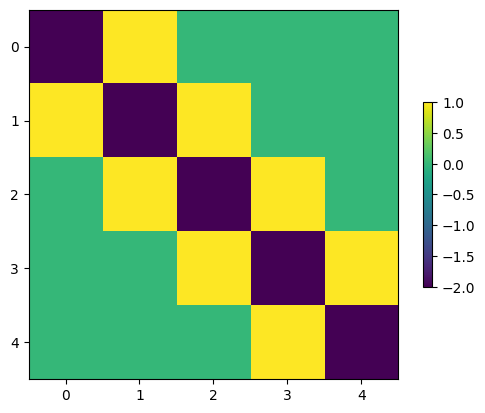

In [3]:
def derivative_1d_stencil ( n = 5 , offsets = [-1,0,1] , order = 2 , h = None ) :

    """
    Name: derivative_1d_stencil
    Purpose: what this subroutine computes and why
    Author: Joshua Belieu | Fletch
    Date written: 2025-09-24
    Last modified: 2025-09-24
    Inputs:
    - arg1: type ... meaning/units/shape
    - arg2: type ... meaning/units/shape
    Outputs:
    - ret: type ... meaning/units/shape
    Dependencies:
    - SubroutineA, SubroutineB, ...
    """

    if h == None :
        print ( "h not specified, assuming h = 1.0" )
        h = 1.0

    weights = [ float(num) for num in np.array(fd_weights ( offsets , order )).flatten()]

    stencil = diags ( weights , offsets , shape = ( n , n ) ) / h**order

    return stencil.toarray()

'''
unit test
'''

test_deriv = derivative_1d_stencil()
plt.imshow(test_deriv)
plt.colorbar(shrink=0.5);

1.5.b

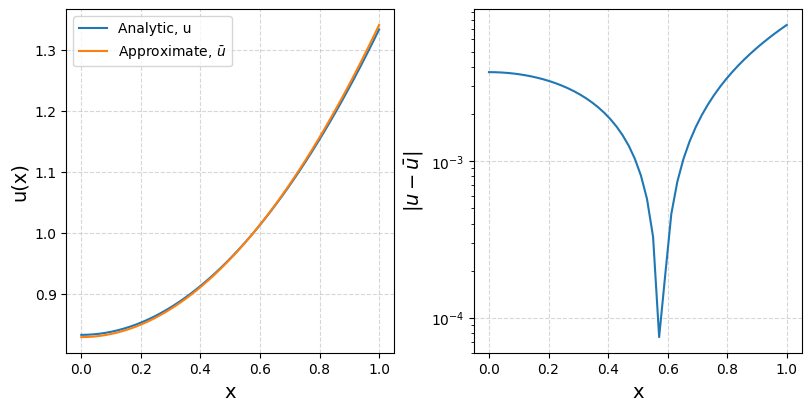

In [92]:
x_low = 0.
x_high = 1.
n = 50
h = x_high / ( n-1 )

offsets = [ -1 , 0 , 1 ]
derivative_matrix = derivative_1d_stencil(n,h=h)
stencil_nobc = derivative_matrix.copy()
left_neumann = np.array([ float(num) for num  in np.array(fd_weights ( [0,1,2],1 )).flatten()])
right_neumann = np.array([float(num) for num  in np.array(fd_weights ( [-2,-1,0],1 )).flatten()])

derivative_matrix[0,0:3] = left_neumann / h
derivative_matrix[-1,-3:] = right_neumann / h

f = np.ones ( n )
f[0]=0.

norm_cond = np.ones ( n ) * h
derivative_matrix = np.vstack([derivative_matrix, norm_cond])
f = np.append(f,1.0)

u = np.linalg.lstsq ( derivative_matrix , f ,rcond=None)[0]
u_norm = simpson ( u , dx = h )
u /= u_norm

x = np.linspace ( x_low , x_high , n )
true = 0.5*x**2+5/6

fig,axs = plt.subplots(1,2,figsize=(8,4),constrained_layout=True)
# plt.figure(figsize=(8,6))
axs[0].plot( x , true ,label='Analytic, u')
axs[0].plot( x , u , label = r'Approximate, $\bar{u}$')
axs[0].set_xlabel('x', fontsize=14)
axs[0].set_ylabel('u(x)', fontsize=14)
axs[0].grid(ls='--',alpha=0.5)
axs[1].plot( x , np.abs(u - true))
axs[1].set_xlabel('x', fontsize=14)
axs[1].set_ylabel(r'$|u-\bar{u}|$', fontsize=14)
axs[1].set_yscale('log')
axs[1].grid(ls='--',alpha=0.5)
axs[0].legend();

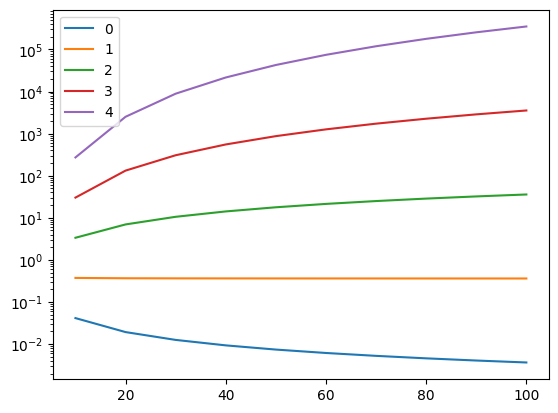

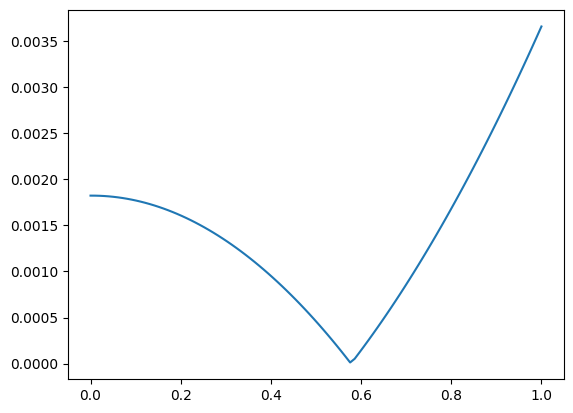

In [82]:
x_low = 0.
x_high = 1.
n_list = range(10,110,10)

offsets = [ -1 , 0 , 1 ]
h_list = []
max_error_list = []

for n in n_list : 

    h = x_high / ( n-1 )

    derivative_matrix = derivative_1d_stencil(n,h=h)

    left_neumann = np.array([ float(num) for num  in np.array(fd_weights ( [0,1],1 )).flatten()])
    right_neumann = np.array([float(num) for num  in np.array(fd_weights ( [-1,0],1 )).flatten()])

    derivative_matrix[0,0:len(left_neumann)] = left_neumann / h
    derivative_matrix[-1,-len(right_neumann):] = right_neumann / h

    f = np.ones ( n )
    f[0]=0.

    norm_cond = np.ones ( n ) * h
    derivative_matrix = np.vstack([derivative_matrix, norm_cond])
    f = np.append(f,1.0)

    u = np.linalg.lstsq ( derivative_matrix , f ,rcond=None)[0]
    u_norm = simpson ( u , dx = h )
    u /= u_norm
    x = np.linspace ( x_low , x_high , n )
    true = 0.5*x**2+5/6

    h_list.append(h)
    max_error_list.append ( np.max ( np.abs ( u - true )))


for order in range ( 0 , 4 + 1 ) :
    plt.plot ( n_list , np.array(max_error_list)/np.array(h_list)**order ,label=order)
plt.yscale('log')
plt.legend();
plt.figure()
plt.plot( x , np.abs(u - true));